Scratch development for continual learning loop

What I want to do:
- There is a continual learning env that lets an agent learn on a stream of tasks
- At specified intervals, we can evaluate the continual learner on _every_ task in the training set

Things to consider:
- can I use the ML10 environments in this setting? goals are obscured, what does that mean?
- how many steps per env do I want? I think CW uses 1 million? check this, also, with PPO is this enough? (CW uses SAC)
- randomisation of task goals - CW seems to have randomisation settings for the benchmark. MT and ML have randomised environments. How should we handle these tasks?

### Other thoughts
Next step is to integrate the continual environment and evaluation loop into a training loop. We want to use the PPO algorithm provided (or something similar), but provide it with arbitrary policy / value networks (i.e. our own).

Testing learning in this way might require setting up some command line 'args' stuff - might be easier to match it with PPO
But is this the simplest testing method?

Should look at policy storage - how can I use that?

Also - continue to look at how to get continual environments to work. Continual world has randomization handlers, success counters etc.



In [1]:
# import sys
# sys.path.append('./algorithms/')
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy
from typing import Any, Dict, List, Tuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# get RL2 trained policy for example
RUN_FOLDER = './logs/logs_ML10-v2/rl2_73__25:10_21:13:08'
policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
encoder_net = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [3]:
class ActorCritic(nn.Module):

    def __init__(self, policy, encoder):
        super().__init__()
        self.policy = policy
        self.encoder = encoder
    
    def get_actor_params(self):
        return self.policy.get_actor_params()

    def get_critic_params(self):
        return self.policy.get_critic_params()

    def forward_actor(self, inputs):
        return self.policy.forward_actor(inputs)

    def forward_critic(self, inputs):
        return self.policy.forward_critic(inputs)
    
    
    ## TODO: what to do about 'sample'? check what this arg is?
    def forward(self, actions, states, rewards, hidden_state, return_prior=False, sample=True, detach_every=None):
        # really want this to take the inputs for the encoder and then output the outputs of the policy
        # we only want to get the prior when there are no previous rewards, actions or hidden states
        # should only occur at the very start of the continual learning process
        if hidden_state is None:
            _, latent_mean, latent_logvar, hidden_state = self.encoder.prior(states.shape[1]) # check that this gets the batch size?
        else:
            _, latent_mean, latent_logvar, hidden_state = self.encoder(actions, states, rewards, hidden_state, return_prior, sample, detach_every)
        
        latent_mean = F.relu(latent_mean)
        latent_logvar = F.relu(latent_logvar)
        latent = torch.cat((latent_mean, latent_logvar), dim=-1).reshape(1, -1)
        # none for belief and task
        return self.policy(states, latent, None, None), hidden_state, latent


    def act(self, actions, states, rewards, hidden_state, deterministic=False):
        """
        Returns the (raw) actions and their value.
        """
        policy_out, hidden_state, latent = self.forward(actions, states, rewards, hidden_state)
        value, actor_features = policy_out
        dist = self.policy.dist(actor_features)
        if deterministic:
            if isinstance(dist, FixedCategorical):
                action = dist.mode()
            else:
                ## TODO: should the 'mean' have brackets or not?
                action = dist.mean()
        else:
            action = dist.sample()

        return value, action, hidden_state, latent

    def get_value(self, state, latent, belief=None, task=None):
        value, _ = self.policy.forward(state, latent, belief, task)
        return value

    def evaluate_actions(self, prev_state, latent, belief, task, actions):
        """Call policy eval, set task, belief to None"""
        return self.policy.evaluate_actions(prev_state, latent, belief, task, actions)
        

In [4]:
#1. get prior at start for base latent
# (does this reset the hidden state? I think so)
#2. feed policy observation + latent -> gets action, obs, reward, done
#3. feed encoder action, obs, reward, done and hidden state to get next action
import metaworld
import random

ml10 = metaworld.ML10() # Construct the benchmark, sampling tasks

training_envs = []
for name, env_cls in ml10.test_classes.items():
  env = env_cls()
  task = random.choice([task for task in ml10.test_tasks
                        if task.env_name == name])
  env.set_task(task)
  training_envs.append(env)

In [5]:

from algorithms.custom_storage import CustomOnlineStorage
from algorithms.custom_ppo import CustomPPO
# combined network with encoder + policy
ac = ActorCritic(policy_net, encoder_net)
agent = CustomPPO(
    actor_critic=ac,
    value_loss_coef = 1,
    entropy_coef = 0.001,
    policy_optimiser='adam',
    policy_anneal_lr=False,
    train_steps = 2,
    optimiser_vae=None,
    lr = 0.001,
    eps=1.0e-8,
    clip_param = 0.2,
    ppo_epoch = 3,
    use_huber_loss = True,
    use_clipped_value_loss=True,
    context_window=None
)
env = training_envs[0]

storage = CustomOnlineStorage(
    500, 1, env.observation_space.shape[0]+1, 0, 0,
    env.action_space, ac.encoder.hidden_size, ac.encoder.latent_dim, False)




In [6]:

# get it going
NUM_EP = 1
reward = action = hidden_state = None
done = False
episode_reward = 0
episode_steps = 0

for i in range(NUM_EP):
    obs, _ = env.reset()
    while not done:
        obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1)).to(device)[None,:,:]
        if hidden_state is not None:
            reward = torch.from_numpy(np.array(reward).reshape(1, -1))[None,:,:].float().to(device)
            action = torch.from_numpy(action)[None, None,:].to(device)
            # print(reward)
        value, act, hidden_state, latent = agent.act(action, obs.float(), reward, hidden_state)
        action = act.cpu().detach().numpy()[0]

        next_obs, reward, terminated, truncated, info = env.step(action)
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

        # create mask for episode ends
        masks_done = torch.FloatTensor([[0.0] if done else [1.0] ]).to(device)
        # bad_mask is true if episode ended because time limit was reached
        # don't care for metaworld
        bad_masks = torch.FloatTensor([[0.0]]).to(device)

        storage.insert(
            state=torch.from_numpy(np.append(obs, 0).reshape(1, -1)),
            belief=None,
            task=None,
            actions=act,
            rewards_raw=torch.from_numpy(np.array(reward).reshape(1, -1)),
            rewards_normalised=torch.from_numpy(np.array(reward).reshape(1, -1)),#rew_normalised,
            value_preds=value,
            masks=masks_done,
            bad_masks=bad_masks,
            done=torch.from_numpy(np.array(done, dtype=float)),
            hidden_states = hidden_state.squeeze(1),
            latent = latent#.unsqueeze(1),
        )
# s, m, l, h = ac.encoder.prior(np.append(obs, 0).reshape(1, -1).shape[1])
# print(s.shape, m.shape, l.shape, h.shape)

In [7]:
agent.update(
    storage,
    encoder = None
)

NameError: name 'warnings' is not defined

In [10]:
latent = [storage.latent[0].detach().clone()]
latent[0].requires_grad = True

h = storage.hidden_states[0].detach()
for i in range(storage.actions.shape[0]):
    # reset hidden state of the GRU when we reset the task
    h = ac.encoder.reset_hidden(h, storage.done[i + 1])

    _, tm, tl, h = ac.encoder(
        storage.actions.float()[i:i + 1],
        storage.next_state[i:i + 1],
        storage.rewards_raw[i:i + 1],
        h,
        sample=False,
        return_prior=False,
        detach_every=None
    )
    # latent_sample.append(ts)
    latent.append(torch.cat((tm, tl), dim = -1))
    # latent_mean.append(tm)
    # latent_logvar.append(tl)

# if update_idx == 0:
#     try:
#         assert (policy_storage.latent - latent).sum() == 0
#         # assert (torch.cat(policy_storage.latent_mean) - torch.cat(latent_mean)).sum() == 0
#         # assert (torch.cat(policy_storage.latent_logvar) - torch.cat(latent_logvar)).sum() == 0
#     except AssertionError:
#         warnings.warn('You are not recomputing the embeddings correctly!')
#         import pdb
#         pdb.set_trace()

# policy_storage.latent = latent

In [11]:
(torch.cat(storage.latent) - torch.cat(latent[1:])).sum()

tensor(37878.9688, device='cuda:0', grad_fn=<SumBackward0>)

In [8]:
next_value = ac.get_value(obs, latent)
storage.compute_returns(next_value=next_value, use_gae=True, gamma=0.99, tau =0.95, use_proper_time_limits=False)
# -- get action values --
advantages = storage.returns[:-1] - storage.value_preds[:-1]
advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)

In [9]:
# storage.before_update(ac)
actions = storage.actions
prev_state = storage.prev_state[:-1]
latents = torch.stack(storage.latent[:-1])
print(actions.size(), prev_state.size(), latents.size())

torch.Size([500, 1, 4]) torch.Size([500, 1, 40]) torch.Size([499, 1, 256])


In [10]:
storage.before_update(ac)

In [11]:
# device = 'cpu'
# storage.to_device(device)
# storage.action_log_probs = storage.action_log_probs.to(device)

In [27]:
gen = storage.feed_forward_generator(
    advantages=advantages,
    num_mini_batch=5,
    mini_batch_size = 100
)

for g in gen:
    state_batch, actions_batch, latent_batch, value_preds_batch, \
    return_batch, old_action_log_probs_batch, adv_targ = g
    print([b.requires_grad for b in g])
    values, action_log_probs, dist_entropy = \
    v, a, d = ac.evaluate_actions(prev_state=state_batch, latent=latent_batch,
                                        belief=None, task=None,
                                        actions=actions_batch)

[False, False, False, True, True, False, True]
[False, False, False, True, True, False, True]
[False, False, False, True, True, False, True]
[False, False, False, True, True, False, True]
[False, False, False, True, True, False, True]


In [30]:
print(v.requires_grad, a.requires_grad, d.requires_grad)

True True True


In [24]:
# state_batch, actions_batch, latent_batch, value_preds_batch, return_batch, old_action_log_probs_batch, adv_targ

NameError: name 'state_batch' is not defined

In [17]:
n = next(gen)

/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [12,0,0], thread: [96,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [12,0,0], thread: [97,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [12,0,0], thread: [98,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [12,0,0], thread: [99,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [12,0,0], thread: [100,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [12,0,

RuntimeError: CUDA error: device-side assert triggered

In [14]:
import torch
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

num_mini_batch = 5
mini_batch_size = 100

num_steps, num_processes = storage.rewards_raw.size()[0:2]
batch_size = num_processes * num_steps

if mini_batch_size is None:
    assert batch_size >= num_mini_batch, (
        "PPO requires the number of processes ({}) "
        "* number of steps ({}) = {} "
        "to be greater than or equal to the number of PPO mini batches ({})."
        "".format(num_processes, num_steps, num_processes * num_steps,
                    num_mini_batch))
    mini_batch_size = batch_size // num_mini_batch
sampler = BatchSampler(
    SubsetRandomSampler(range(batch_size)),
    mini_batch_size,
    drop_last=True)
indices_log = []
for i, indices in enumerate(sampler):
    indices_log.append((i, indices))
    print(i, 'start ok')
    state_batch = storage.prev_state[:-1].reshape(-1, *storage.prev_state.size()[2:])[indices]
    print(i, 'state ok', state_batch.size())
    latent_batch = torch.cat(storage.latent[:-1])[indices]
    print(i, 'latent ok', latent_batch.size())

    print(len(indices), storage.actions.reshape(-1, storage.actions.size(-1)).size(), storage.actions.size())
    # actions_batch = storage.actions.reshape(-1, storage.actions.size(-1))[indices]
    # print(i, 'actions ok', actions_batch.size())

    value_preds_batch = storage.value_preds[:-1].reshape(-1, 1)[indices]
    print(i, 'values ok', value_preds_batch.size())
    return_batch = storage.returns[:-1].reshape(-1, 1)[indices]
    print(i, 'returns ok', return_batch.size() )

    old_action_log_probs_batch = storage.action_log_probs.reshape(-1, 1)[indices]
    print(i, 'log_probs ok', old_action_log_probs_batch.size() )

    adv_targ = advantages.reshape(-1, 1)[indices]
    print(i, 'advantages ok', adv_targ.size() )

0 start ok
0 state ok torch.Size([100, 40])
0 latent ok torch.Size([100, 256])
100 torch.Size([500, 4]) torch.Size([500, 1, 4])
0 values ok torch.Size([100, 1])
0 returns ok torch.Size([100, 1])
0 log_probs ok torch.Size([100, 1])
0 advantages ok torch.Size([100, 1])
1 start ok
1 state ok torch.Size([100, 40])
1 latent ok torch.Size([100, 256])
100 torch.Size([500, 4]) torch.Size([500, 1, 4])


/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [16,0,0], thread: [96,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [16,0,0], thread: [97,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [16,0,0], thread: [98,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [16,0,0], thread: [99,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [16,0,0], thread: [100,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:84: operator(): block: [16,0,

RuntimeError: CUDA error: device-side assert triggered

In [15]:
idx_array = [[indices] for indices in sampler]
# for indices in sampler:
#     # print(indices)
#     idx_array.append(indices)
#     # state_batch = storage.prev_state[:-1].reshape(-1, *storage.prev_state.size()[2:])[indices]

In [18]:
import numpy as np
[(np.max(idx), np.min(idx)) for idx in idx_array]

[(496, 2), (498, 4), (499, 0), (495, 3), (490, 10)]

In [55]:
# torch.cat(storage.latent[:-1]).reshape(-1, 1)[idx_array[0]]
storage.actions.reshape(-1, storage.actions.size(-1))[idx_array[4]].size()

torch.Size([100, 4])

In [41]:
# storage.prev_state[:-1].reshape(-1,1)[idx_array[4]].size()
for i in range(len(idx_array)):
    print(torch.cat(storage.latent).reshape(-1,1)[idx_array[0]])

tensor([[0.0205],
        [0.0000],
        [0.0322],
        [0.0000],
        [0.0616],
        [0.0027],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0171],
        [0.0000],
        [0.0860],
        [0.0504],
        [0.0000],
        [0.0000],
        [0.1657],
        [0.0184],
        [0.0305],
        [0.0000],
        [0.0959],
        [0.0000],
        [0.0000],
        [0.1637],
        [0.0059],
        [0.0308],
        [0.0214],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.1116],
        [0.0000],
        [0.0000],
        [0.0173],
        [0.0000],
        [0.0000],
        [0.0917],
        [0.0000],
        [0.0000],
        [0.0896],
        [0.0971],
        [0.0000],
        [0.0000],
        [0.1537],
        [0.0000],
        [0.0288],
        [0.0569],
        [0.0000],
        [0.0000],
        [0.0332],
        [0.0000],
        [0.0000],
        [0.0000],
        [0

In [29]:
# use feed forward generator
# requires advantages
# need to compute returns
# advantages are just returns - value preds
storage.returns

tensor([[[0.0740]],

        [[0.0875]],

        [[0.0769]],

        [[0.0758]],

        [[0.0842]],

        [[0.0809]],

        [[0.0802]],

        [[0.0819]],

        [[0.0670]],

        [[0.0726]],

        [[0.0831]],

        [[0.0830]],

        [[0.0822]],

        [[0.0837]],

        [[0.0784]],

        [[0.0827]],

        [[0.0763]],

        [[0.0799]],

        [[0.0799]],

        [[0.0810]],

        [[0.0670]],

        [[0.0578]],

        [[0.0771]],

        [[0.0731]],

        [[0.0798]],

        [[0.0768]],

        [[0.0826]],

        [[0.0774]],

        [[0.0832]],

        [[0.0785]],

        [[0.0803]],

        [[0.0782]],

        [[0.0779]],

        [[0.0689]],

        [[0.0650]],

        [[0.0776]],

        [[0.0826]],

        [[0.0829]],

        [[0.0779]],

        [[0.0804]],

        [[0.0791]],

        [[0.0798]],

        [[0.0829]],

        [[0.0827]],

        [[0.0831]],

        [[0.0700]],

        [[0.0814]],

        [[0.0

In [65]:
### also some wrappers used 
# pop successes records the successes during training
# randomisation settings - seems that they set all tasks at the start
class ContinualEnv(gym.Env):
    """
    Based on continual world env design:
    https://github.com/awarelab/continual_world/blob/main/continualworld/envs.py
    """
    def __init__(self, envs: List[gym.Env], steps_per_env: int):

        ## good check to do
        for i in range(len(envs)):
            assert envs[0].action_space == envs[i].action_space

        self.action_space = envs[0].action_space
        self.observation_space = deepcopy(envs[0].observation_space)
        # what is remove goal bounds? don't think need for meta-learning

        self.envs = envs
        self.num_envs = len(envs)
        self.steps_per_env = steps_per_env
        self.steps_limit = self.num_envs * self.steps_per_env
        self.cur_step = 0
        self.cur_seq_idx = 0

    def _get_envs(self):
        return self.envs

    def step(self, action: Any) -> Tuple[np.ndarray, float, bool, Dict]:
        obs, reward, terminated, truncated, info = self.envs[self.cur_seq_idx].step(action)
        done = terminated or truncated
        info["seq_idx"] = self.cur_seq_idx

        self.cur_step += 1
        if self.cur_step % self.steps_per_env == 0:
            done = True
            info["TimeLimit.truncated"] = True

            self.cur_seq_idx += 1

        return obs, reward, done, info

    def reset(self) -> np.ndarray:
        obs, _, self.envs[self.cur_seq_idx].reset()
        return obs


In [66]:
import metaworld
import random

ml10 = metaworld.ML10() # Construct the benchmark, sampling tasks

training_envs = []
for name, env_cls in ml10.test_classes.items():
  env = env_cls()
  task = random.choice([task for task in ml10.test_tasks
                        if task.env_name == name])
  env.set_task(task)
  training_envs.append(env)

In [111]:
def evaluate_all_envs(envs_to_do, num_episodes = 10, agent = None):

    results = {i: dict() for i in range(len(envs_to_do))}
    for i, env in enumerate(envs_to_do):
        results[i] = evaluate_single_env(env, num_episodes, agent)
        _, _ = env.reset()

    return results

def evaluate_single_env(env, num_episodes, agent):
    results = {'episode_reward': [], 'success': []} 
    action = reward = hidden_state = None
    for episode in range(num_episodes):
        done = False
        episode_reward = 0
        success = 0
        episode_len = 0
        obs, _ = env.reset()

        while not done:
            if agent is not None:
                obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1))[None,:,:].float().to(device)
                if hidden_state is not None:
                    reward = torch.from_numpy(np.array(reward).reshape(1, -1))[None,:,:].float().to(device)
                    action = torch.from_numpy(action)[None, None,:].float().to(device)
                _, act, hidden_state = agent.act(action, obs, reward, hidden_state)
                action = act.cpu().detach().numpy()[0]
            else:
                action = env.action_space.sample()
            next_obs, reward, truncated, terminated, info = env.step(action)
            done = truncated or terminated
            obs = next_obs

            episode_reward += reward
            success = info['success']
            episode_len += 1

            # stop on success for eval
            if success == 1:
                done = True

        results['episode_reward'].append(episode_reward / episode_len)
        results['success'].append(success)

    return results



In [113]:

results = evaluate_all_envs(training_envs, num_episodes = 10, agent = ac)

In [119]:
## training loop
# while the whole continual env is not done
# train on each env sequentially
# periodically evaluate on all envs

agent = ActorCritic(policy_net, encoder_net)
cont_env = ContinualEnv(training_envs, 10)
eval_freq = 10
num_steps = 0
eval_results = dict()
while cont_env.cur_step < cont_env.steps_limit:
    # do each env
    obs = cont_env.reset()
    done = False
    while not done:
        if agent is not None:
            obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1))[None,:,:].float().to(device)
            if hidden_state is not None:
                reward = torch.from_numpy(np.array(reward).reshape(1, -1))[None,:,:].float().to(device)
                action = torch.from_numpy(action)[None, None,:].float().to(device)
            _, act, hidden_state = agent.act(action, obs, reward, hidden_state)
            action = act.cpu().detach().numpy()[0]
        else:
            action = env.action_space.sample()

        next_obs, reward, done, info = cont_env.step(action)
        obs = next_obs

        # periodically evaluate
        if  (cont_env.cur_step + 1) % eval_freq == 0:
            print(cont_env.cur_step, 'EVALUATING')
            all_envs = cont_env._get_envs()
            eval_results[cont_env.cur_step] = evaluate_all_envs(all_envs, num_episodes = 3)
            eval_results[cont_env.cur_step]['task'] = cont_env.cur_seq_idx
        
    print(cont_env.cur_step, cont_env.cur_seq_idx)


        

9 EVALUATING
10 1
19 EVALUATING
20 2
29 EVALUATING
30 3
39 EVALUATING
40 4
49 EVALUATING
50 5


In [120]:
def unpack_results(results_dict, _iter):
    df = pd.DataFrame(results_dict[_iter])
    task = np.unique(df.task).item()
    res =df\
        .loc[:,[col for col in df.columns if col != 'task']]\
        .reset_index(
            names = 'metric'
        )\
        .melt(
            id_vars = 'metric',
            var_name = 'task'
        )\
        .explode('value')
    res.loc[:, 'iter'] = _iter
    res.loc[:, 'current_task'] = task
    return res


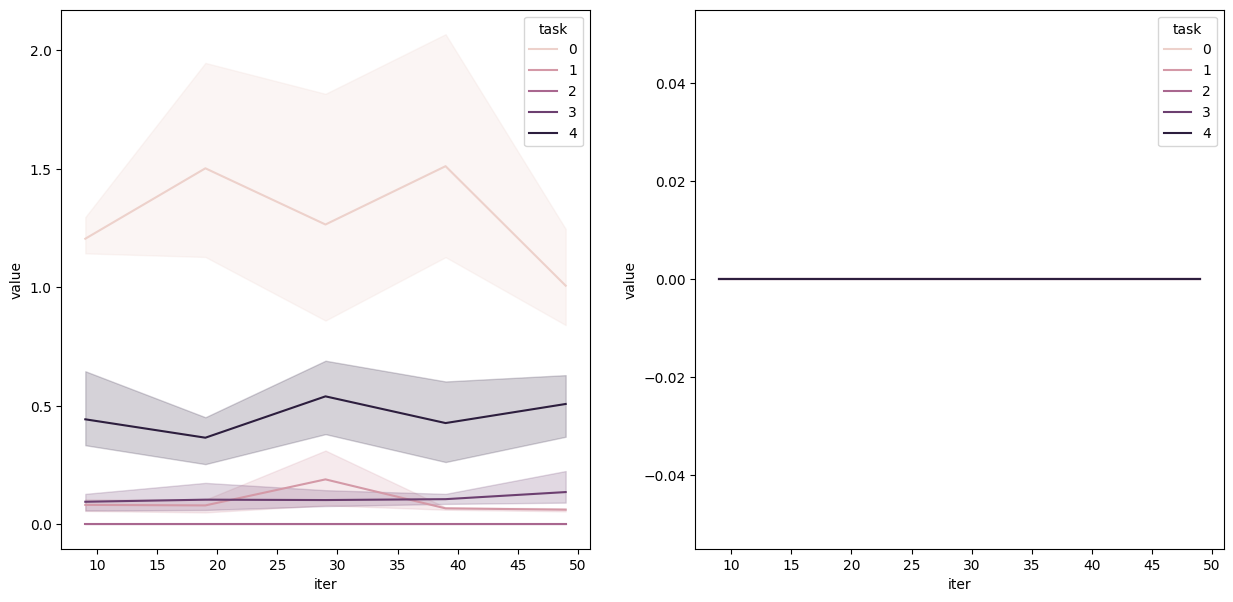

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

res = pd.concat([unpack_results(eval_results, i) for i in eval_results.keys()])

successes = res\
.query('metric=="success"')\
.groupby(['task', 'iter'])\
.agg(
    {
        'current_task':'max',
        'value': lambda x: sum(x) / len(x)
    }
)\
.reset_index()

rewards = res.query('metric=="episode_reward"')

fig, ax = plt.subplots(1,2, figsize = (15, 7))

sns.lineplot(
    data = rewards,
    x = 'iter',
    y = 'value',
    hue = 'task',
    ax = ax[0]
)

sns.lineplot(
    data = successes,
    x = 'iter',
    y = 'value',
    hue = 'task',
    ax = ax[1]
)

plt.show();

In [ ]:
pd.json_normalize(eval_results)

In [ ]:
import pandas as pd
df = pd.DataFrame(eval_results)
df

In [ ]:
pd.json_normalize(df.iloc[0, 0], max_level=0)

In [ ]:
[(k, [(i, pd.v) for i, v in v.items()]) for k, v in eval_results.items()]

In [ ]:
{{'iter': k, 'value': pd.json_normalize(v)} for k, v in eval_results.items()}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# example training
### set the environment
env = training_envs[0]
### create a policy / actor critic
# policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
# we can update this
actor_critic = model.Policy(
    env.observation_space.shape,
    env.action_space,
    base_kwargs={'recurrent': True})
actor_critic.to(device)


### set algorithm
ppo_agent = ppo.PPO(
    actor_critic = actor_critic,
    clip_param = 0.2,
    ppo_epoch = 4,
    num_mini_batch = 10,
    value_loss_coef = 0.5,
    entropy_coef = 1.0e-5,
    lr = 1.0e-4,
    eps = 0.99,
    max_grad_norm = 0.5,
    use_clipped_value_loss = False
)

## create rollouts
rollouts = storage.RolloutStorage(
    10, 1, env.observation_space.shape, env.action_space, actor_critic.recurrent_hidden_state_size
)

# don't know
obs, _ = env.reset()
rollouts.obs[0].copy_(torch.from_numpy(obs))
rollouts.to(device)
episode_rewards = deque(maxlen = 10)

# actual training loop
start = time.time()
num_updates = 10
for j in range(num_updates):
    done = False
    step = 0
    while not done:
        with torch.no_grad():
            # this might be funny
            value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step], rollouts.masks[step], None)
            step += 1

        # step the env
        obs, reward, truncated, terminated, info = env.step(action.detach().to('cpu').numpy()[0])
        done = truncated or terminated
